# Compare Chicago "Postal Codes" to Neighborhood in Denver, Colorado

## Preliminary Setup

##### Import module

In [28]:
import pandas as pd
import numpy as np
#from sodapy import Socrata

from geopy.geocoders import Nominatim
from geopy import distance

import folium
import folium.plugins
from folium.features import *


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests

credentials = pd.read_csv('FoursquareCredentials.csv')
CLIENT_ID = credentials['ID'] # your Foursquare ID
CLIENT_SECRET = credentials['Secret'] # your Foursquare Secret
ACCESS_TOKEN = credentials['Token'] # your FourSquare Access Token
VERSION = credentials['version']

geolocator = Nominatim(user_agent='explorer')

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

##### Universial parameters for the analysis

In [2]:
# radius of venues from center locataion
RADIUS_VENUES = 1500
LIMIT_VENUES = 100
TOP_VENUES = 15

##### Location for Lincoln Park in Denver, Colorado

In [3]:
# get latitude and longitude for Lincol Park Denver Colorado
location = geolocator.geocode('Lincoln Park, Denver, Colorado')
lat_denver = location.latitude
lng_denver = location.longitude
LOCATION_DENVER = (lat_denver, lng_denver)
print(LOCATION_DENVER)

(39.7331384, -105.0052409729397)


In [4]:
# get latitude and longitude for Lincol Park Denver Colorado
location = geolocator.geocode('Lincoln Park, Denver, Colorado')
LOCATION_DENVER = (location.latitude, location.longitude)
print(LOCATION_DENVER)

# plot city on folium maps
map_denver = folium.Map(location=LOCATION_DENVER, zoom_start=12.75)

# add circle radius from Neighborhood Center
folium.Circle(
    LOCATION_DENVER,
    radius=RADIUS_VENUES,
    popup=None,
    color='blue',
    fill=True,
    fill_opacity=0.25).add_to(map_denver)

# draw text on map
folium.Marker(
    LOCATION_DENVER,
    icon=DivIcon(html='<div style="width:125px;'  
                      'border:2px solid blue;'
                      'background-color:#b3e0ff;'
                      'font-weight:bold;'
                      'color:black;'
                      'font-size:15pt">Lincoln Park</div>')
    ).add_to(map_denver)

map_denver

(39.7331384, -105.0052409729397)


##### Location for Postal Codes in Chicago Illinois

In [5]:
# get latitude and longitude for Chicago, Illinois
location = geolocator.geocode('Chicago, Il')
LOCATION_CHICAGO = (location.latitude, location.longitude)
print(LOCATION_CHICAGO)

(41.8755616, -87.6244212)


In [6]:
# load geographic data for Chicago, Illinois
df_all_zip_chicago = pd.read_csv('Chicago_zip_pop.csv')

# get total population in Chicago
TOTAL_POPULATION_CHICAGO = df_all_zip_chicago.loc[0, 'Population - Total']

# remove 1st row which is citywide data
df_all_zip_chicago = df_all_zip_chicago.drop(0)

location_chicago = []
# populate new dataframe
for code, pop in zip(df_all_zip_chicago['Record ID'], df_all_zip_chicago['Population - Total']):
    cnt = 0
    location = None
    while (cnt < 5) & (location == None):
        codeClean = code[9:]
        location = geolocator.geocode(codeClean + ', Illinois')
        cnt += 1
    if location != None:
        location_chicago.append([codeClean, pop, location.latitude, location.longitude])  

# create new dataframe
df_LOCATIONS_CHICAGO = pd.DataFrame(location_chicago, columns=['Postal Code', 'Population', 'Latitude', 'Longitude'])

print(df_LOCATIONS_CHICAGO.shape)
df_LOCATIONS_CHICAGO.head()

(59, 4)


,Postal Code,Population,Latitude,Longitude
0,60601-2018,14675,41.885967,-87.624265
1,60602-2018,1244,41.882993,-87.629251
2,60603-2018,1174,41.880925,-87.628176
3,60604-2018,782,41.878284,-87.628010
4,60605-2018,27519,41.870417,-87.627331


In [7]:
# plot city on folium maps
map_chicago = folium.Map(location=LOCATION_CHICAGO, zoom_start=10)

# add circle radius from Neighborhood Center
for lat, lng in zip(df_LOCATIONS_CHICAGO['Latitude'], df_LOCATIONS_CHICAGO['Longitude']):
    folium.Circle(
        [lat, lng],
        radius=RADIUS_VENUES,
        popup=None,
        color='blue',
        fill=True,
        fill_opacity=0.1).add_to(map_chicago)

# draw text on map
for code, lat, lng in zip(df_LOCATIONS_CHICAGO['Postal Code'], df_LOCATIONS_CHICAGO['Latitude'], df_LOCATIONS_CHICAGO['Longitude']):
    folium.Marker(
        (lat, lng),
        icon=DivIcon(html='<div style="width:32px;'  
                          'border:2px solid blue;'
                          'background-color:#b3e0ff;'
                          'font-weight:bold;'
                          'color:black;'
                          'font-size:10px">'+code[0:5]+'</div>')
        ).add_to(map_chicago)

map_chicago

## Get Venues from Foursquare

##### Get venues around Lincoln Park, Denver, Colorado

In [8]:
# max venues returned
LATITUDE = LOCATION_DENVER[0]
LONGITUDE = LOCATION_DENVER[1]

# make call to foursquare api to get venues
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, RADIUS_VENUES, LIMIT_VENUES)
results = requests.get(url).json()
items = results['response']['groups'][0]['items']

venues_lincolnPark = []
# add venues to list
for idx in range(len(items)):
    lat_ven = items[idx]['venue']['location']['lat']
    lng_ven = items[idx]['venue']['location']['lng']
    venues_lincolnPark.append(['Lincoln Park',
                                LATITUDE,
                                LONGITUDE,
                                items[idx]['venue']['categories'][0]['name'],
                                items[idx]['venue']['name'],
                                lat_ven,
                                lng_ven,
                                distance.distance((LATITUDE, LONGITUDE), (lat_ven, lng_ven)).m])

# make new dataframe from list
dfCols = ['Center', 'Lat_center', 'Lng_center', 'Category', 'Name', 'Lat_venue', 'Lng_venue', 'Distance (m)']
df_venues_lincolnPark = pd.DataFrame(venues_lincolnPark, columns=dfCols)

print(df_venues_lincolnPark.shape)
df_venues_lincolnPark.head()

(89, 8)


,Center,Lat_center,Lng_center,Category,Name,Lat_venue,Lng_venue,Distance (m)
0,Lincoln Park,39.733138,-105.005241,Brewery,Renegade Brewing Company,39.730616,-104.999292,581.849369
1,Lincoln Park,39.733138,-105.005241,Japanese Restaurant,Domo Japanese Country Foods Restaurant,39.738100,-105.005650,551.998957
2,Lincoln Park,39.733138,-105.005241,Arts & Entertainment,Santa Fe Art District,39.730636,-104.998669,628.149538
3,Lincoln Park,39.733138,-105.005241,Steakhouse,The Buckhorn Exchange,39.732205,-105.005067,104.710877
4,Lincoln Park,39.733138,-105.005241,Café,The Molecule Effect,39.735386,-104.998781,607.382310


##### Get venues around Postal Codes in Chicago Illinois

In [9]:
# get venues for all Postal codes in Chicago
venues_chicago = []
for idxA in range(df_LOCATIONS_CHICAGO.shape[0]):
    LATITUDE = df_LOCATIONS_CHICAGO.loc[idxA, 'Latitude']
    LONGITUDE = df_LOCATIONS_CHICAGO.loc[idxA, 'Longitude']
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, LATITUDE, LONGITUDE, VERSION, RADIUS_VENUES, LIMIT_VENUES)
    results = requests.get(url).json()
    items = results['response']['groups'][0]['items']
    for idxV in range(len(items)):
        lat_ven = items[idxV]['venue']['location']['lat']
        lng_ven = items[idxV]['venue']['location']['lng']
        venues_chicago.append([df_LOCATIONS_CHICAGO.loc[idxA, 'Postal Code'],
                               LATITUDE,
                               LONGITUDE,
                               items[idxV]['venue']['categories'][0]['name'],
                               items[idxV]['venue']['name'],
                               lat_ven,
                               lng_ven,
                               distance.distance((LATITUDE, LONGITUDE), (lat_ven, lng_ven)).m])

# make new dataframe from list
dfCols = ['Center', 'Lat_center', 'Lng_center', 'Category', 'Name', 'Lat_venue', 'Lng_venue', 'Distance (m)']
df_venues_chicago = pd.DataFrame(venues_chicago, columns=dfCols)

print(df_venues_chicago.shape)
df_venues_chicago.head()

(4585, 8)


,Center,Lat_center,Lng_center,Category,Name,Lat_venue,Lng_venue,Distance (m)
0,60601-2018,41.885967,-87.624265,Salad Place,sweetgreen,41.884964,-87.624728,117.807054
1,60601-2018,41.885967,-87.624265,Tour Provider,Chicago Architecture Center,41.887720,-87.623650,201.330157
2,60601-2018,41.885967,-87.624265,Hotel,Virgin Hotels Chicago,41.886065,-87.625853,132.270677
3,60601-2018,41.885967,-87.624265,Hotel,"LondonHouse Chicago, Curio Collection by Hilton",41.887832,-87.625426,228.510689
4,60601-2018,41.885967,-87.624265,Theater,The Chicago Theatre,41.885539,-87.627151,244.210848


## Clean Data for Test "Logestic Regression"

##### Parameters

In [10]:
# Parameter for distance divisions
DISTANCE_DIVISION = 10

##### Data  and analysis for Lincoln Park, Colorado

In [11]:
# concat the two dataframes
df_venues = pd.concat([df_venues_lincolnPark, df_venues_chicago]).reset_index(drop=True)

# dummy variables for the "Category" column
df_venues = pd.get_dummies(df_venues, prefix=['Category'], columns=['Category'])

# delete unwanted culumns
df_venues = df_venues.drop(columns=['Lat_center', 'Lng_center', 'Name', 'Lat_venue', 'Lng_venue'])

print(df_venues.shape[0])
df_venues.head()

4674


,Center,Distance (m),Category_ATM,Category_Afghan Restaurant,Category_African Restaurant,Category_Airport,Category_Airport Service,Category_Airport Terminal,Category_American Restaurant,Category_Amphitheater,...,Category_Vietnamese Restaurant,Category_Warehouse Store,Category_Waterfront,Category_Weight Loss Center,Category_Whisky Bar,Category_Wine Bar,Category_Wine Shop,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio
0,Lincoln Park,581.849369,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Lincoln Park,551.998957,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Lincoln Park,628.149538,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Lincoln Park,104.710877,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Lincoln Park,607.382310,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Get data and perform analysis

In [12]:
# get data for "Lincoln Park"
df_lincolnpark = df_venues[df_venues['Center'] == 'Lincoln Park'].reset_index(drop=True)

# get independent variables
X = df_lincolnpark.drop(columns=['Center', 'Distance (m)']).values.astype(int)

# get dependent variables
y = df_lincolnpark['Distance (m)'].values // (RADIUS_VENUES // DISTANCE_DIVISION)

# standardize data
X = preprocessing.StandardScaler().fit(X).transform(X)

# logistic regression analysis
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X,y)

# predict results using training (lincoln park, colorado) data
yhat = LR.predict(X)

# accuracy of model
accuracy_score(y, yhat)

0.7303370786516854

##### Data  and analysis for Chicago, Illinois

In [13]:
ACCURACY_DICT = {}
for idx in range(df_LOCATIONS_CHICAGO.shape[0]):
    # get venues for Chicago Postal Code
    df_chicagoCode = df_venues[df_venues['Center'] == df_LOCATIONS_CHICAGO.loc[idx, 'Postal Code']].reset_index(drop=True)

    # get independent variables
    X = df_chicagoCode.drop(columns=['Center', 'Distance (m)']).values.astype(int)

    # get dependent variables
    y = df_chicagoCode['Distance (m)'].values // (RADIUS_VENUES // DISTANCE_DIVISION)

    # standardize data
    X = preprocessing.StandardScaler().fit(X).transform(X)

    # predict results using training (lincoln park, colorado) data
    yhat = LR.predict(X)

    # accuracy of model
    ACCURACY_DICT[idx] = accuracy_score(y, yhat)

# sort with most common first
ACCURACY_DICT = sorted(ACCURACY_DICT.items(), key=lambda x: x[1], reverse=True)

Top postal codes the most common with lincoln park

In [28]:
TOPCODE = 10

# plot city on folium maps
map_chicago_top5 = folium.Map(location=LOCATION_CHICAGO, zoom_start=10)

# add circle radius from Neighborhood Center
for idx in range(TOPCODE):
    areaIDX = ACCURACY_DICT[idx][0]
    folium.Circle(
        [df_LOCATIONS_CHICAGO.loc[areaIDX, 'Latitude'], df_LOCATIONS_CHICAGO.loc[areaIDX, 'Longitude']],
        radius=RADIUS_VENUES,
        popup=None,
        color='blue',
        fill=True,
        fill_opacity=0.5).add_to(map_chicago_top5)
    
# draw text on map
for idx in range(TOPCODE):
    areaIDX = ACCURACY_DICT[idx][0]
    code = df_LOCATIONS_CHICAGO.loc[areaIDX, 'Postal Code']
    prtStr = str(code[0:5])+': Similarity = '+str(round(ACCURACY_DICT[idx][1],2))
    folium.Marker(
        [df_LOCATIONS_CHICAGO.loc[areaIDX, 'Latitude'], df_LOCATIONS_CHICAGO.loc[areaIDX, 'Longitude']],
        icon=DivIcon(html='<div style="width:115px;'  
                          'border:2px solid blue;'
                          'background-color:#b3e0ff;'
                          'font-weight:bold;'
                          'color:black;'
#                          'font-size:10px">'+'#'+str(idx+1)+': '+code[0:5]+'</div>')
                          'font-size:10px">'+prtStr+'</div>')
        ).add_to(map_chicago_top5)

map_chicago_top5

## Show Resulst with Crime Data

##### Load crime data in Chicago

In [15]:
# load geographic data for Chicago, Illinois
df_all_crime_chicago = pd.read_csv('chicago_crime.csv')

# keep only particular crimes in dataset
lst = ['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY', 'CRIM SEXUAL ASSAULT', 'CRIMINAL SEXUAL ASSAULT', 'HOMICIDE', 'KIDNAPPING', 'OFFENSE INVOLVING CHILDREN', 'ROBBERY', 'SEX OFFENSE']
df_all_crime_chicago = df_all_crime_chicago[df_all_crime_chicago['Primary Type'].isin(lst)]

# drop rows where 'Latitude' or 'Longitude' is not a number
df_all_crime_chicago.drop(df_all_crime_chicago[(np.isnan(df_all_crime_chicago['Latitude'])) |
                                               (np.isnan(df_all_crime_chicago['Longitude']))].index, inplace=True)

# reset index
df_all_crime_chicago = df_all_crime_chicago.reset_index(drop=True)

print(df_all_crime_chicago.shape)
df_all_crime_chicago.head()

(93962, 22)


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,11937949,JC566932,12/31/2019 08:35:00 PM,064XX S WESTERN AVE,031B,ROBBERY,ARMED - OTHER FIREARM,COMMERCIAL / BUSINESS OFFICE,False,False,...,16.0,66,03,1161478.0,1861938.0,2019,12/10/2020 03:48:06 PM,41.776833,-87.683578,"(41.776832515, -87.683577859)"
1,11666065,JC237357,04/25/2019 01:49:00 AM,068XX S JUSTINE ST,051A,ASSAULT,AGGRAVATED - HANDGUN,RESIDENCE - PORCH / HALLWAY,False,False,...,16.0,67,04A,1167182.0,1859434.0,2019,12/10/2020 03:48:06 PM,41.769841,-87.662739,"(41.769841049, -87.662738721)"
2,11613029,JC173331,02/28/2019 04:00:00 PM,035XX W 55TH ST,1582,OFFENSE INVOLVING CHILDREN,CHILD PORNOGRAPHY,SCHOOL - PUBLIC BUILDING,False,False,...,14.0,63,17,1153756.0,1867915.0,2019,12/10/2020 03:48:06 PM,41.793391,-87.711728,"(41.793390915, -87.711728299)"
3,11596162,JC152837,02/14/2019 09:03:00 PM,072XX S UNIVERSITY AVE,0498,BATTERY,"AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...",RESIDENCE,False,True,...,5.0,69,04B,1185134.0,1857272.0,2019,12/10/2020 03:48:06 PM,41.763505,-87.597003,"(41.76350538, -87.597002882)"
4,11936658,JC565320,12/29/2019 04:00:00 PM,097XX S INGLESIDE AVE,1020,ARSON,BY FIRE,RESIDENCE - GARAGE,False,False,...,8.0,50,09,1184269.0,1840576.0,2019,12/09/2020 03:45:09 PM,41.717710,-87.600694,"(41.717710033, -87.600694219)"


##### Count crimes around each top postal code

In [16]:
# make lists from dataframes for faster computing
all_crimes_chicago = df_all_crime_chicago[['Latitude', 'Longitude']].values
location_chicago = df_LOCATIONS_CHICAGO[['Latitude', 'Longitude']].values


# double venue radius for crime radius 
RADIUS_chicago_crime = RADIUS_VENUES*2 #m

# dictionary with crime count
crime_count = {}
for idx in range(df_LOCATIONS_CHICAGO.shape[0]):
    crime_count[idx] = 0

# count crimes close to code
for idxA in range(TOPCODE):
    for idxC in range(len(all_crimes_chicago)):
        if distance.distance(location_chicago[ACCURACY_DICT[idxA][0]], all_crimes_chicago[idxC]).m < RADIUS_chicago_crime:
            crime_count[ACCURACY_DICT[idxA][0]] += 1

Use population to find the crimes/population for each postal code

In [17]:
crime_per_population = {}
for idx in range(df_LOCATIONS_CHICAGO.shape[0]):
    crime_per_population[idx] = crime_count[idx] / df_LOCATIONS_CHICAGO.loc[idx, 'Population'].astype(float)
    if np.isnan(crime_per_population[idx]):
        crime_per_population[idx] = 0.0
    
# sort with most common first
#crime_per_population = sorted(crime_per_population.items(), key=lambda x: x[1], reverse=True)

<ipython-input-17-d5393ea4130b>:3: RuntimeWarning: invalid value encountered in double_scalars
  crime_per_population[idx] = crime_count[idx] / df_LOCATIONS_CHICAGO.loc[idx, 'Population'].astype(float)


In [20]:
# plot city on folium maps
map_chicago_crime = folium.Map(location=LOCATION_CHICAGO, zoom_start=10)

# add circle radius from Neighborhood Center
for idx in range(TOPCODE):
    areaIDX = ACCURACY_DICT[idx][0]
    folium.Circle(
        [df_LOCATIONS_CHICAGO.loc[areaIDX, 'Latitude'], df_LOCATIONS_CHICAGO.loc[areaIDX, 'Longitude']],
        radius=RADIUS_chicago_crime,
        popup=None,
        color='red',
        fill=True,
        fill_opacity=0.5).add_to(map_chicago_crime)
    folium.Circle(
        [df_LOCATIONS_CHICAGO.loc[areaIDX, 'Latitude'], df_LOCATIONS_CHICAGO.loc[areaIDX, 'Longitude']],
        radius=RADIUS_VENUES,
        popup=None,
        color='blue',
        fill=True,
        fill_opacity=0.5).add_to(map_chicago_crime)
    
    
    
# draw text on map
for idx in range(TOPCODE):
    areaIDX = ACCURACY_DICT[idx][0]
    code = df_LOCATIONS_CHICAGO.loc[areaIDX, 'Postal Code']
    prtStr = str(code[0:5])+': Similarity = '+str(round(ACCURACY_DICT[idx][1],2)) + ' & Crime/Person = '+str(round(crime_per_population[areaIDX],2))
    folium.Marker(
        [df_LOCATIONS_CHICAGO.loc[areaIDX, 'Latitude'], df_LOCATIONS_CHICAGO.loc[areaIDX, 'Longitude']],
        icon=DivIcon(html='<div style="width:230px;'  
                          'border:2px solid blue;'
                          'background-color:#b3e0ff;'
                          'font-weight:bold;'
                          'color:black;'
                          'font-size:10px">'+prtStr+'</div>')
        ).add_to(map_chicago_crime)

map_chicago_crime

#### Visually compare venues in "Lincoln Park", and Top postal codes in Chicago, Illinois

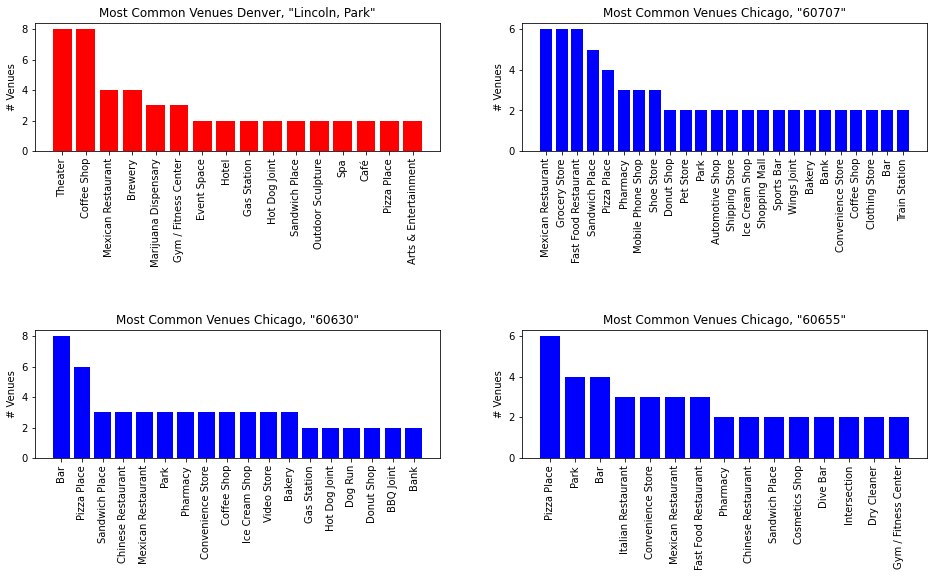

In [19]:
# venues with more than 2 in Lincoln, Park
venues = df_venues_lincolnPark.groupby('Category', as_index=False).count().sort_values('Center', ascending=False).reset_index(drop=True)
venues = venues[venues['Center'] >= 2]
# plot bar graph showing number of venues in location
plt.figure(figsize=(16,8))
plt.subplot(321)
plt.bar(venues.iloc[:,0], venues.iloc[:,1], color='red')
plt.xticks(rotation=90);
plt.ylabel('# Venues');
plt.title('Most Common Venues Denver, "Lincoln, Park"');


# venues with more than 2 in Chicago, 60707
venues = df_venues_chicago[df_venues_chicago['Center'] == '60707-2018']
venues = venues.groupby('Category', as_index=False).count().sort_values('Center', ascending=False).reset_index(drop=True)
venues = venues[venues['Center'] >= 2]
# plot bar graph showing number of venues in location
plt.subplot(322)
plt.bar(venues.iloc[:,0], venues.iloc[:,1], color='blue')
plt.xticks(rotation=90);
plt.ylabel('# Venues');
plt.title('Most Common Venues Chicago, "60707"');


# venues with more than 2 in Chicago, 60630
venues = df_venues_chicago[df_venues_chicago['Center'] == '60630-2018']
venues = venues.groupby('Category', as_index=False).count().sort_values('Center', ascending=False).reset_index(drop=True)
venues = venues[venues['Center'] >= 2]
# plot bar graph showing number of venues in location
plt.subplot(325)
plt.bar(venues.iloc[:,0], venues.iloc[:,1], color='blue')
plt.xticks(rotation=90);
plt.ylabel('# Venues');
plt.title('Most Common Venues Chicago, "60630"');


# venues with more than 2 in Chicago, 60655
venues = df_venues_chicago[df_venues_chicago['Center'] == '60655-2018']
venues = venues.groupby('Category', as_index=False).count().sort_values('Center', ascending=False).reset_index(drop=True)
venues = venues[venues['Center'] >= 2]
# plot bar graph showing number of venues in location
plt.subplot(326)
plt.bar(venues.iloc[:,0], venues.iloc[:,1], color='blue')
plt.xticks(rotation=90);
plt.ylabel('# Venues');
plt.title('Most Common Venues Chicago, "60655"');